In [2]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt


2024-08-09 17:17:55.759305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('../sql/Customer_Behavior.db')

# Define your SQL query
query = "SELECT * FROM E_Comm_Customer_Behavior"

# Use pandas to execute the query and read the data into a DataFrame
df = pd.read_sql_query(query, conn)

df.head()


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,TRUE,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,FALSE,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,TRUE,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,FALSE,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,TRUE,55,Unsatisfied


In [5]:
# Load the Income_by_City table
query_income = "SELECT * FROM Income_by_City"
df_income = pd.read_sql_query(query_income, conn)

# Merge the DataFrames on the City column
df_merged = pd.merge(df, df_income, on='City', how='left')

# Display the merged DataFrame
# print(df_merged.head())
df_merged.head()


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level,median_income
0,101,Female,29,New York,Gold,1120.20,14,4.6,TRUE,25,Satisfied,100340.434483
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,FALSE,18,Neutral,73435.833333
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,TRUE,42,Unsatisfied,65355.204698
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,FALSE,12,Satisfied,109217.584416
4,105,Male,27,Miami,Silver,720.40,13,4.0,TRUE,55,Unsatisfied,71618.016129


In [6]:
query_generations = "SELECT * FROM Generations"
df_generations = pd.read_sql_query(query_generations, conn)
df_generations.rename(columns={'Current_Ages': 'Age'}, inplace=True)
df_generations.head()


,Generation,Born,Age
0,WWII,1922,102
1,WWII,1923,101
2,WWII,1924,100
3,WWII,1925,99
4,WWII,1926,98


In [7]:
# Merge the DataFrames
df_augmented = pd.merge(df_merged, df_generations, on='Age', how='left')

# Close the database connection
conn.close()

# Display the augmented DataFrame
df_augmented.head()


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level,median_income,Generation,Born
0,101,Female,29,New York,Gold,1120.20,14,4.6,TRUE,25,Satisfied,100340.434483,Millenials,1995
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,FALSE,18,Neutral,73435.833333,Millenials,1990
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,TRUE,42,Unsatisfied,65355.204698,Millenials,1981
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,FALSE,12,Satisfied,109217.584416,Millenials,1994
4,105,Male,27,Miami,Silver,720.40,13,4.0,TRUE,55,Unsatisfied,71618.016129,Gen Z,1997


In [9]:
#Checking NaN values
df_augmented.isna().any(axis=0)


Customer ID                 False
Gender                      False
Age                         False
City                        False
Membership Type             False
Total Spend                 False
Items Purchased             False
Average Rating              False
Discount Applied            False
Days Since Last Purchase    False
Satisfaction Level           True
median_income               False
Generation                  False
Born                        False
dtype: bool

In [10]:
#Cleaning NaN values
df_cleaned = df_augmented.dropna()
df_cleaned.isna().any(axis=0)
df_augmented = df_cleaned


Customer ID                 False
Gender                      False
Age                         False
City                        False
Membership Type             False
Total Spend                 False
Items Purchased             False
Average Rating              False
Discount Applied            False
Days Since Last Purchase    False
Satisfaction Level          False
median_income               False
Generation                  False
Born                        False
dtype: bool

In [13]:
# Mapping Gender
df_augmented['Gender'] = df_augmented['Gender'].map({'Male': 1, 'Female': 0})

# Mapping Discount Applied
# df_augmented['Discount Applied'] = df_augmented['Discount Applied'].map({True: 1, False: 0})
df_augmented['Discount Applied'] = df_augmented['Discount Applied'].map({
                                                                        'TRUE': 1, 'FALSE': 0})

# One-hot encoding for City, Membership Type, and Satisfaction Level
df_augmented = pd.get_dummies(df_augmented, columns=[
                              'City', 'Membership Type', 'Satisfaction Level'], drop_first=True)

# Display the transformed DataFrame
# print(df.head())
df_augmented.head()


,Customer ID,Gender,Age,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,median_income,Generation,Born,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Satisfaction Level_Satisfied,Satisfaction Level_Unsatisfied
0,101,0,29,1120.20,14,4.6,1,25,100340.434483,Millenials,1995,False,False,False,True,False,True,False,True,False
1,102,1,34,780.50,11,4.1,0,18,73435.833333,Millenials,1990,False,True,False,False,False,False,True,False,False
2,103,0,43,510.75,9,3.4,1,42,65355.204698,Millenials,1981,False,False,False,False,False,False,False,False,True
3,104,1,30,1480.30,19,4.7,0,12,109217.584416,Millenials,1994,False,False,False,False,True,True,False,True,False
4,105,1,27,720.40,13,4.0,1,55,71618.016129,Gen Z,1997,False,False,True,False,False,False,True,False,True


In [14]:
len(df_augmented)


348

In [15]:
data = df_augmented

# Encoding categorical variables
le_generation = LabelEncoder()
data['Generation'] = le_generation.fit_transform(data['Generation'])
# data.drop('Generation', axis=1, inplace=True)


# Dropping 'Customer ID' as it is not a useful feature and separating the target variable
target_column = 'median_income'
X = data.drop(['Customer ID', target_column], axis=1)
y = data[target_column]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Regression
knn = KNeighborsRegressor(n_neighbors=5)  # Adjusted to n_neighbors=3
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate KNN model
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

print(f'KNN Mean Squared Error: {knn_mse}')
print(f'KNN R^2 Score: {knn_r2}')

# Deep Learning Model
# model = tf.keras.models.Sequential([
#    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#    tf.keras.layers.Dense(64, activation='relu'),
#    tf.keras.layers.Dense(1)  # Linear activation for regression
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu',
                          input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Linear activation for regression
])

model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['mean_squared_error', 'mae'])

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Model training with early stopping
history = model.fit(X_train_scaled, y_train, validation_split=0.2,
                    epochs=100, batch_size=32, callbacks=[early_stopping])

# history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=30, batch_size=32)

# Predicting with the deep learning model
y_pred_dl = model.predict(X_test_scaled)

# Evaluating the deep learning model
dl_mse = mean_squared_error(y_test, y_pred_dl)
dl_r2 = r2_score(y_test, y_pred_dl)

print(f'Deep Learning Model Mean Squared Error: {dl_mse}')
print(f'Deep Learning Model R^2 Score: {dl_r2}')


KNN Mean Squared Error: 0.0
KNN R^2 Score: 1.0
Epoch 1/100
7/7 [==============================] - 2s 34ms/step - loss: 7393780224.0000 - mean_squared_error: 7393780224.0000 - mae: 84520.6406 - val_loss: 7577647616.0000 - val_mean_squared_error: 7577647616.0000 - val_mae: 85356.4609
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 7393654272.0000 - mean_squared_error: 7393654272.0000 - mae: 84519.8906 - val_loss: 7577507328.0000 - val_mean_squared_error: 7577507328.0000 - val_mae: 85355.6719
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 7393512448.0000 - mean_squared_error: 7393512448.0000 - mae: 84519.0781 - val_loss: 7577347072.0000 - val_mean_squared_error: 7577347072.0000 - val_mae: 85354.7500
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 7393344512.0000 - mean_squared_error: 7393344512.0000 - mae: 84518.1172 - val_loss: 7577150464.0000 - val_mean_squared_error: 7577150464.0000 - val_mae: 85353.6250
Epoch 5/100


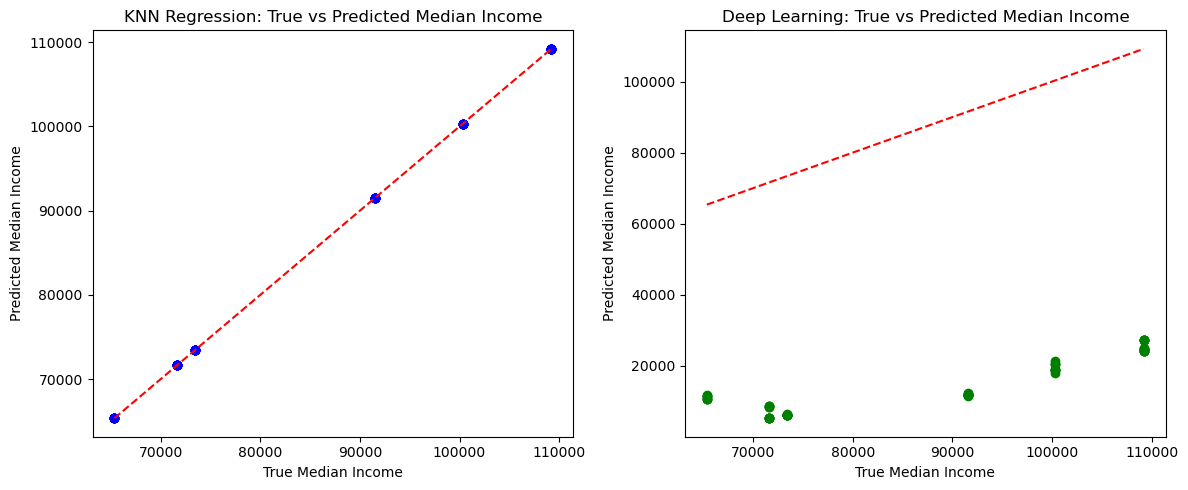

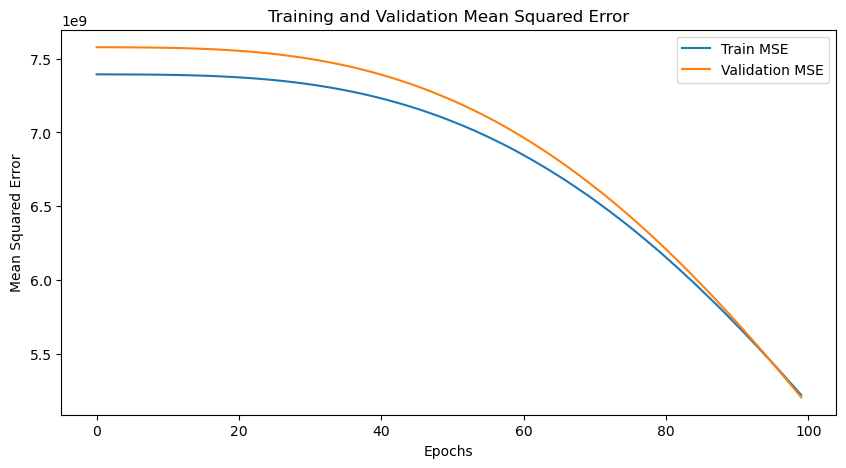

In [16]:
# Visualization of KNN results
plt.figure(figsize=(12, 5))

# Scatter plot of true vs. predicted values for KNN
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_knn, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], color='red', linestyle='--')
plt.title('KNN Regression: True vs Predicted Median Income')
plt.xlabel('True Median Income')
plt.ylabel('Predicted Median Income')

# Visualization of Deep Learning results
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_dl, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], color='red', linestyle='--')
plt.title('Deep Learning: True vs Predicted Median Income')
plt.xlabel('True Median Income')
plt.ylabel('Predicted Median Income')

plt.tight_layout()
plt.show()

# Training and validation loss plot for the deep learning model
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()
